In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_e.shape

(60, 1)

In [5]:
sales_e.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_e['Sales'].sum()

4925930

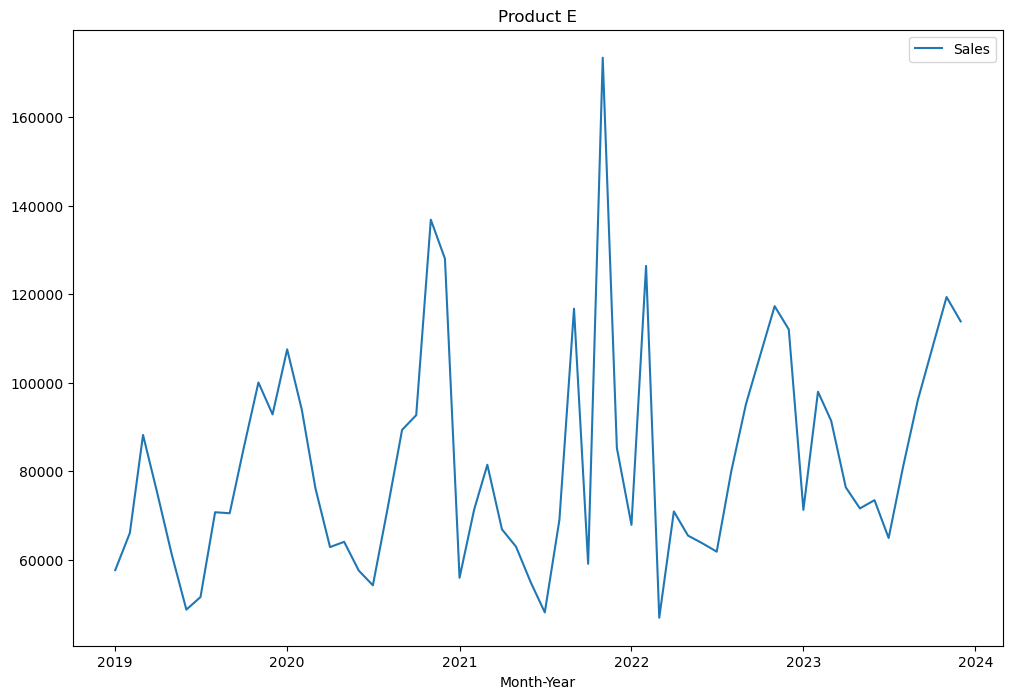

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e)
plt.title('Product E')
plt.show()

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_e)

ADF Statistics: -1.547517694729824
p- value: 0.5098879012430942
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_e_diff= sales_e.diff().dropna()

Text(0.5, 1.0, 'Product E- First Difference')

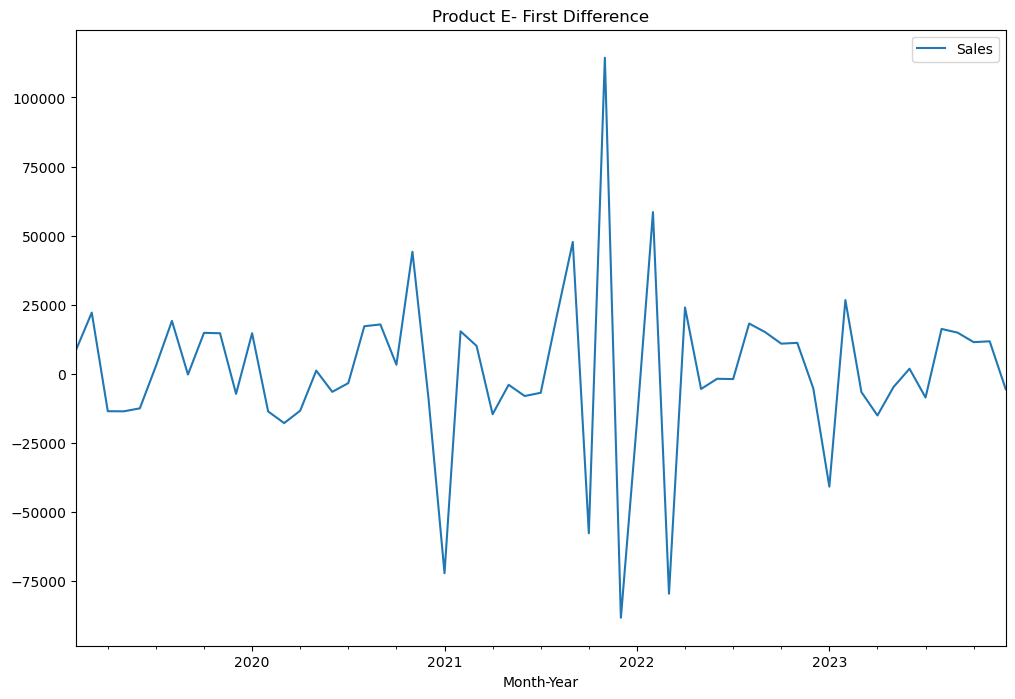

In [11]:
sales_e_diff.plot(figsize=(12, 8))
plt.title('Product E- First Difference')

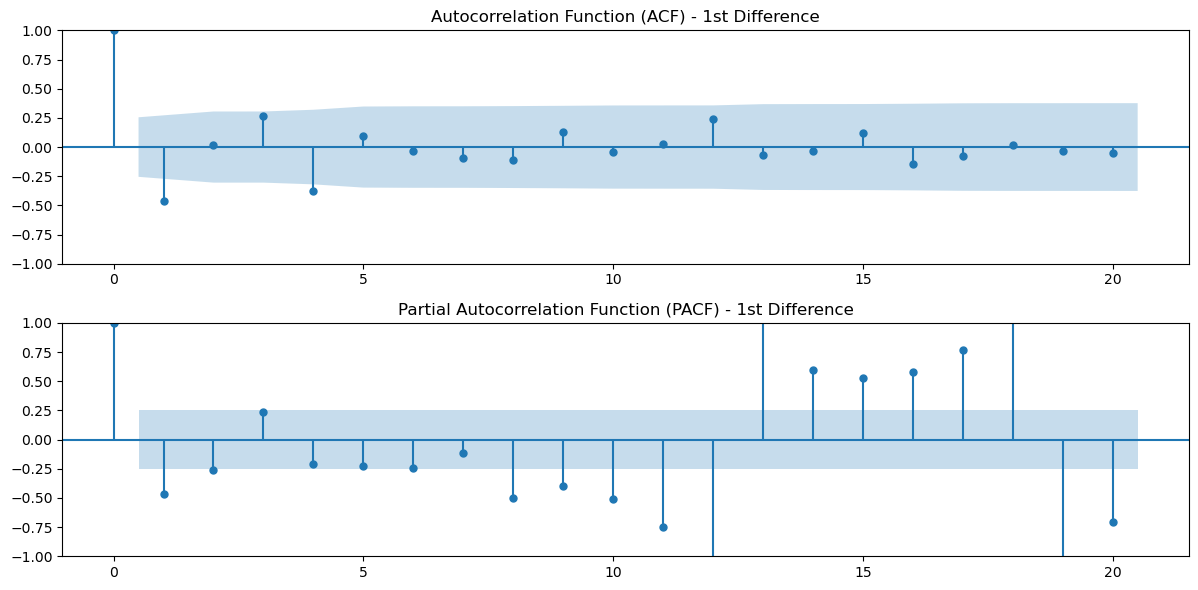

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_e_diff)

ADF Statistics: -6.125883961889508
p- value: 8.631648926998655e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_e[:54]
test=sales_e[54:]

In [15]:
print(len(train), len(test))

54 6


In [16]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_e, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_e)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [17]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1230.849967  1244.642011   8453.756719  9.212786e+07   9598.325977
17  5  2  1232.494680  1248.257015   8558.967161  9.543213e+07   9768.936889
13  4  1  1232.792232  1244.613984  16426.514916  3.755841e+08  19379.993275
16  5  1  1234.082883  1247.874926  15164.999853  3.215002e+08  17930.426378
4   1  1  1236.871380  1242.782256  20439.647120  5.630009e+08  23727.639081
11  3  2  1237.683056  1249.504807  23097.597210  6.726254e+08  25935.022546
1   0  1  1238.250646  1242.191230  20418.571197  5.321774e+08  23068.971131
7   2  1  1238.366051  1246.247219  26600.113305  8.922088e+08  29869.865083
2   0  2  1238.618968  1244.529843  20361.324772  5.399796e+08  23237.461732
15  5  0  1238.760325  1250.582077  22593.520639  7.297856e+08  27014.543899
12  4  0  1239.237180  1249.088639  24920.511696  8.351123e+08  28898.309731
9   3  0  1239.408049  1247.289216  28438.463337  1.075012e+09  32787.372187

In [18]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -608.425
Date:                Tue, 14 May 2024   AIC                           1230.850
Time:                        05:15:44   BIC                           1244.642
Sample:                    01-01-2019   HQIC                          1236.154
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8883      0.241      3.688      0.000       0.416       1.360
ar.L2         -0.0199      0.248     -0.080      0.936      -0.507       0.467
ar.L3         -0.0436      0.221     -0.198      0.8

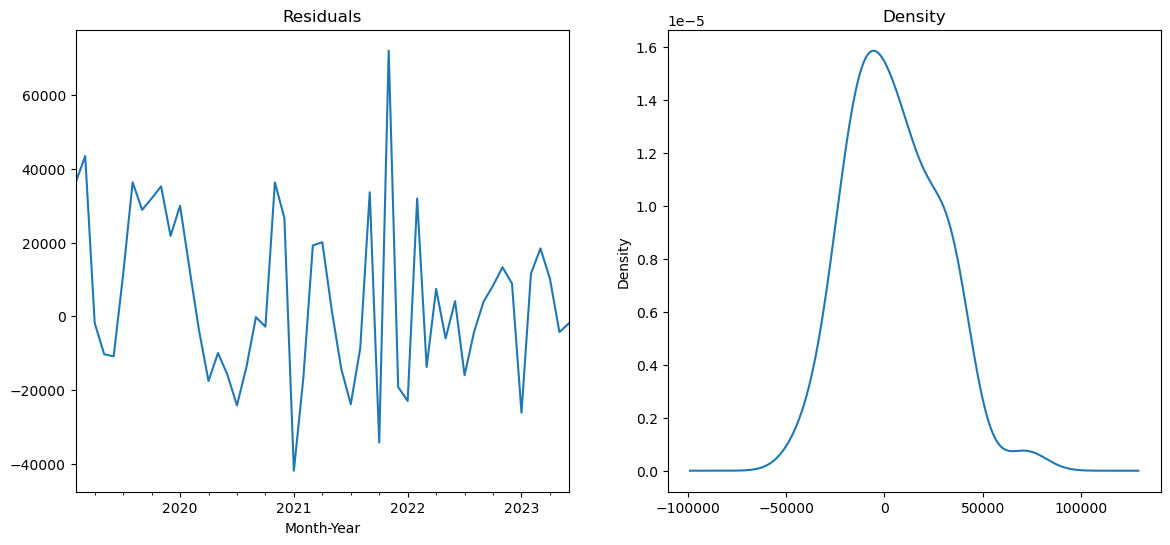

In [19]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

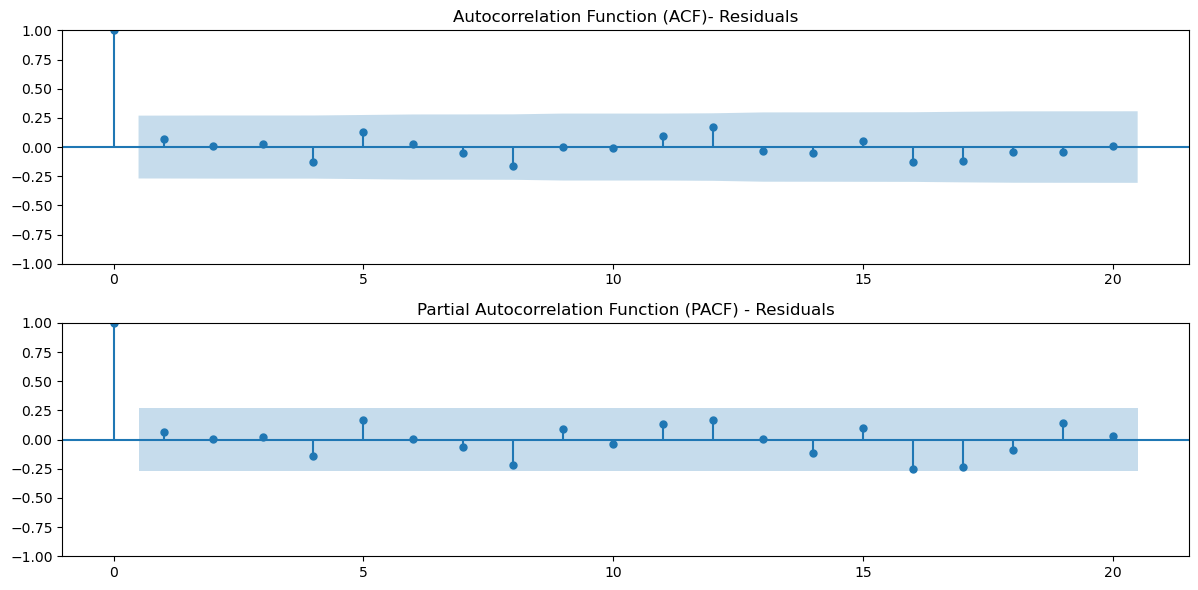

In [20]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

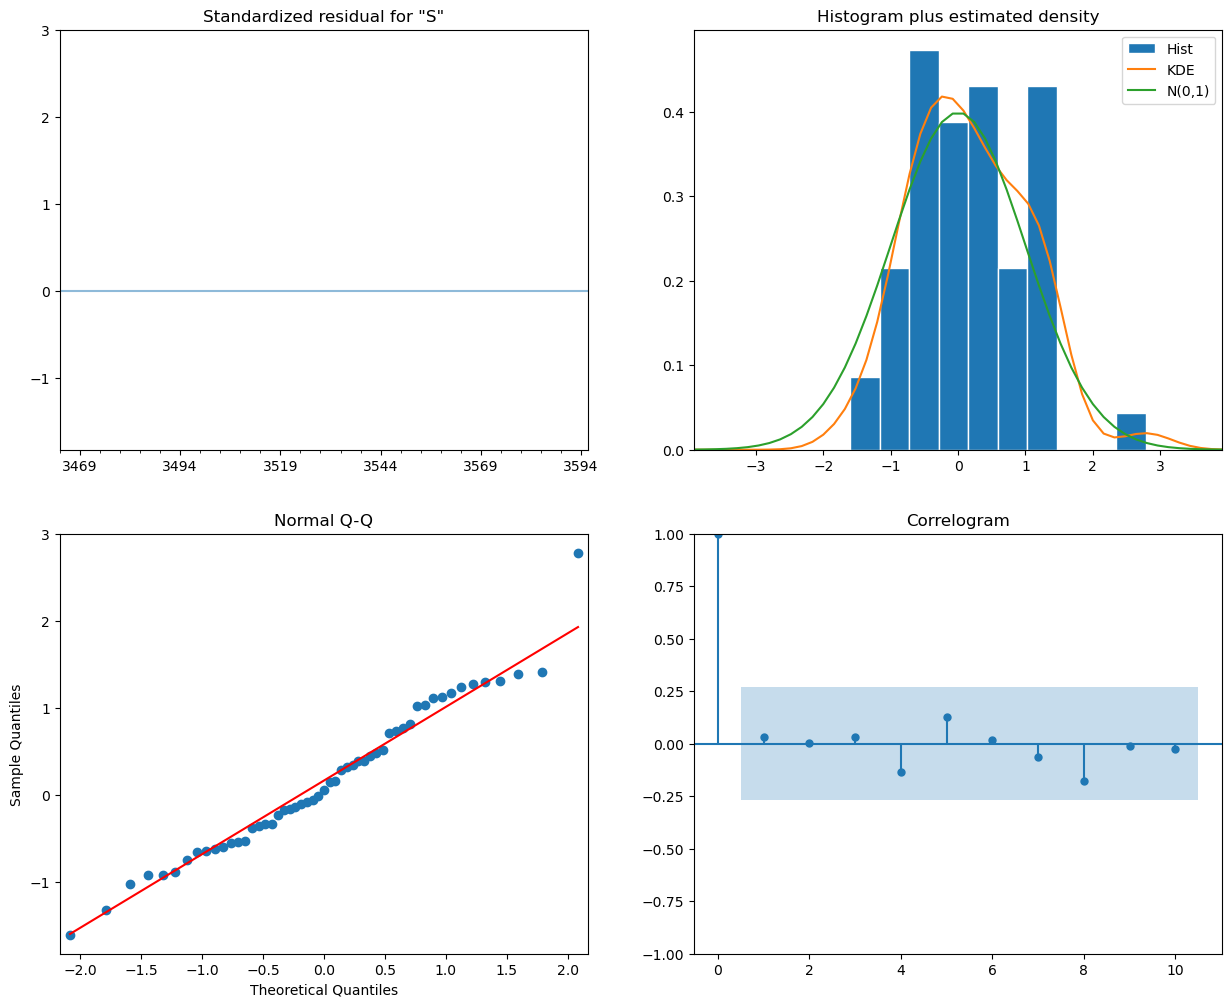

In [21]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [22]:
#pred=model.forecast(steps= len(test))
#sales_e['Forecast_ARIMA']=[None]*len(train) + list(pred)
#plt.figure(figsize=(14, 6))
#sales_e.plot()

In [23]:
pred=model_arima.predict(start=len(train), end=(len(sales_e)-1), dynamic = True)
sales_e['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product E')

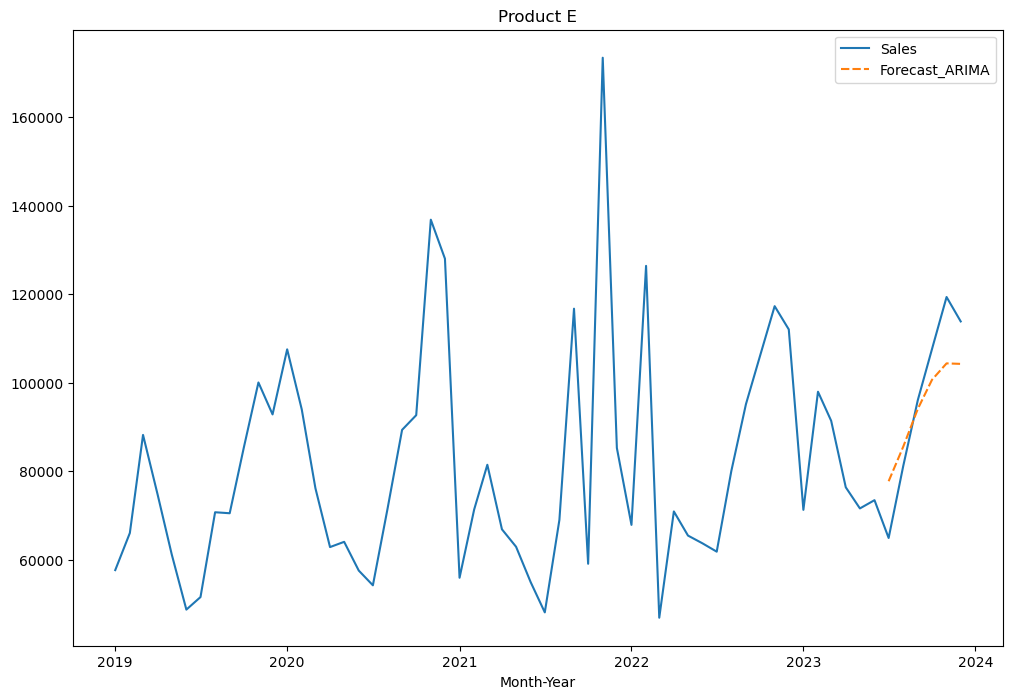

In [24]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e)
plt.title('Product E')

In [25]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 8453.75671890078
MAPE - ARIMA: 0.09110299598742005
MSE - ARIMA: 92127861.56666546
RMSE - ARIMA: 9598.325977307994


# FORECASTING

In [60]:
f_arima= ARIMA(sales_e['Sales'], order=(4,1,2))
model_f_arima=f_arima.fit()

In [61]:
forecast_=model_f_arima.predict(start=len(sales_e), end=(len(sales_e)+6), dynamic = True)

In [62]:
forecast_

2024-01-01    104547.838313
2024-02-01     96508.672852
2024-03-01     85390.627439
2024-04-01     78221.211398
2024-05-01     76017.070755
2024-06-01     77800.055524
2024-07-01     83984.329218
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product E')

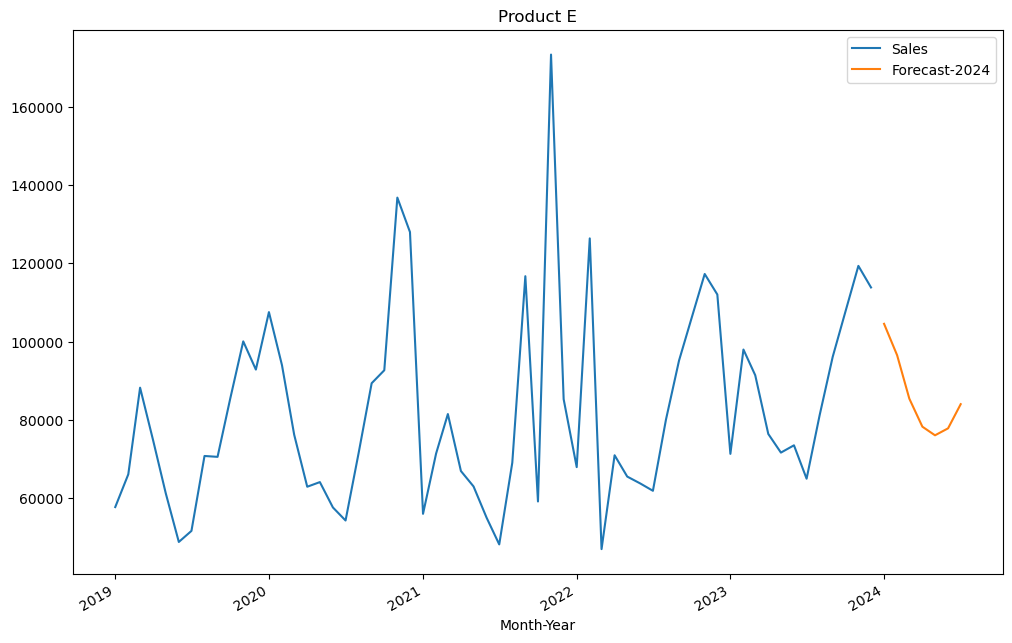

In [63]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales']])
forecast_.plot(legend=True, label='Forecast-2024')
plt.title('Product E')

In [64]:
arima_forecast_model=model_f_arima.get_forecast(steps=6)

In [65]:
mean_forecast= arima_forecast_model.predicted_mean
dates = mean_forecast.index

In [66]:
confidence_intervals= arima_forecast_model.conf_int()

In [67]:
print(mean_forecast,confidence_intervals)

2024-01-01    104547.838313
2024-02-01     96508.672852
2024-03-01     85390.627439
2024-04-01     78221.211398
2024-05-01     76017.070755
2024-06-01     77800.055524
Freq: MS, Name: predicted_mean, dtype: float64              lower Sales    upper Sales
2024-01-01  56351.944691  152743.731934
2024-02-01  48232.047232  144785.298471
2024-03-01  36611.872479  134169.382399
2024-04-01  28515.345952  127927.076845
2024-05-01  26148.035121  125886.106389
2024-06-01  27944.146787  127655.964260


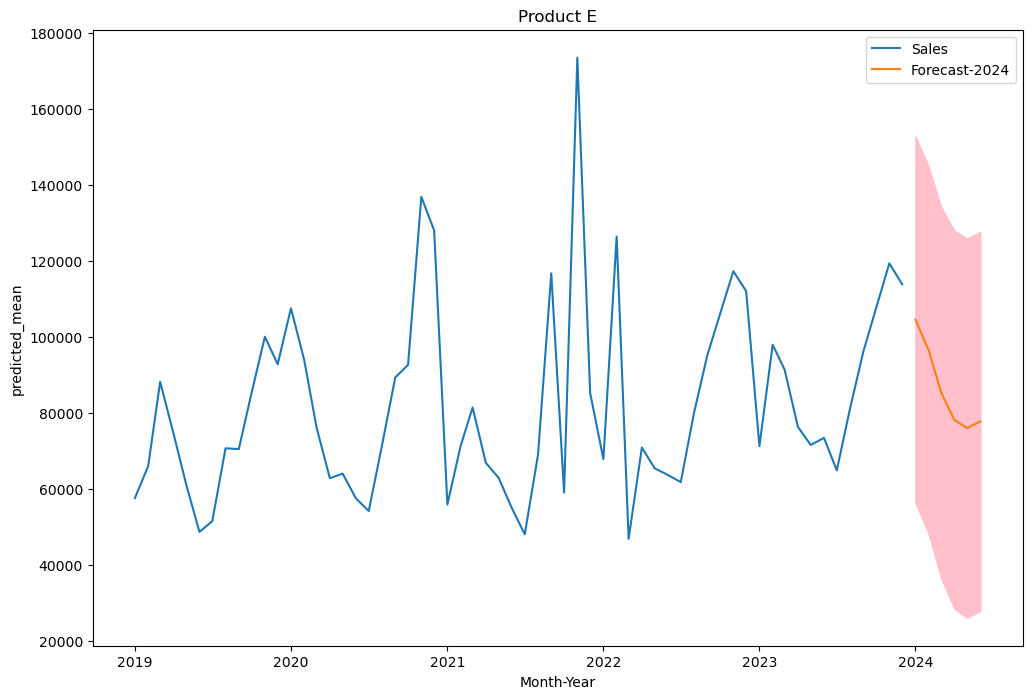

In [68]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales']])
sns.lineplot(mean_forecast,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals['lower Sales'],confidence_intervals['upper Sales'],color='pink')
plt.title('Product E')
plt.show()

# SARIMA

In [37]:
import statsmodels.api as sm

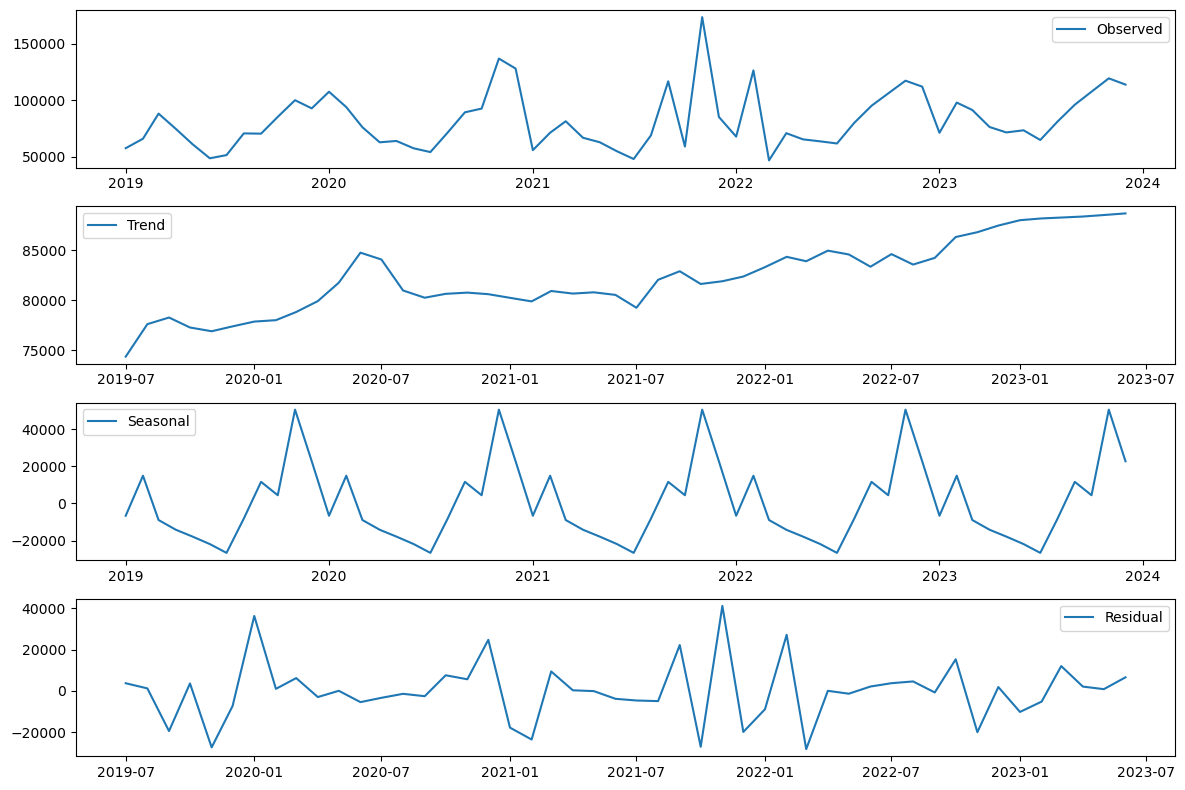

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_e['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

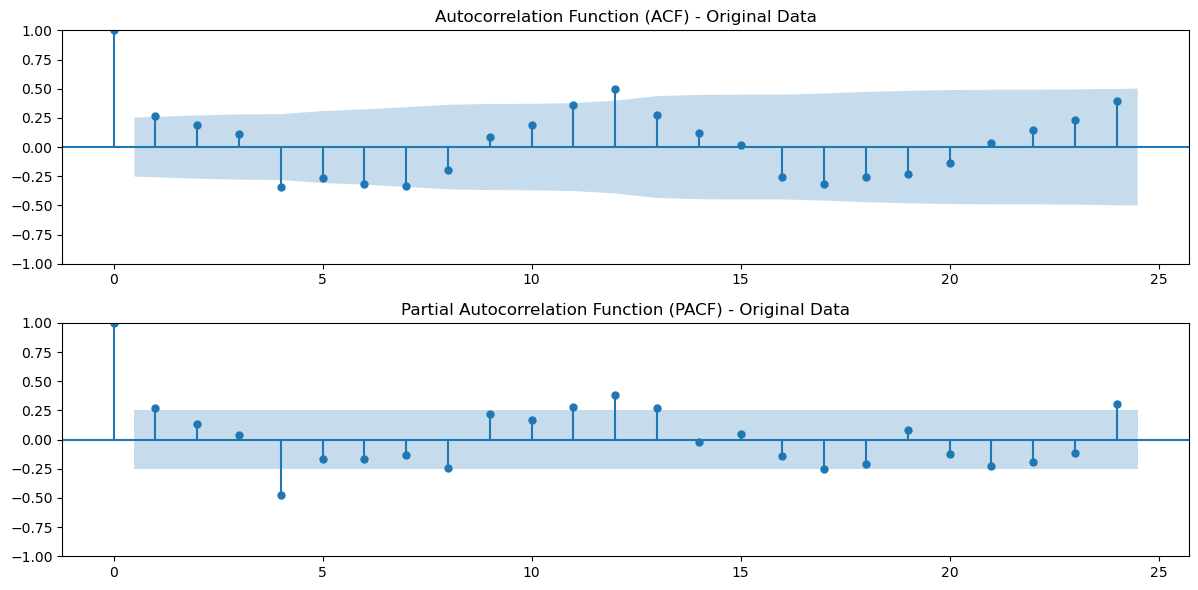

In [39]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

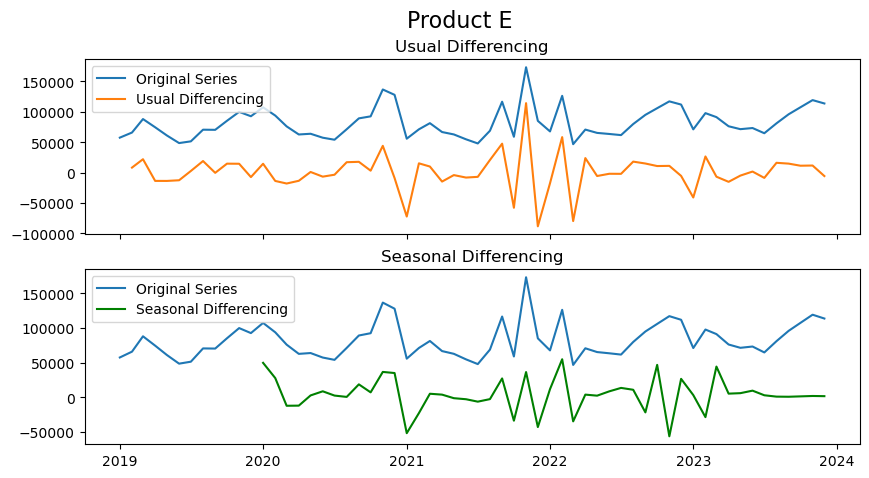

In [40]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_e['Sales'], label='Original Series')
axes[0].plot(sales_e['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_e['Sales'], label='Original Series')
axes[1].plot(sales_e['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product E', fontsize=16)
plt.show()

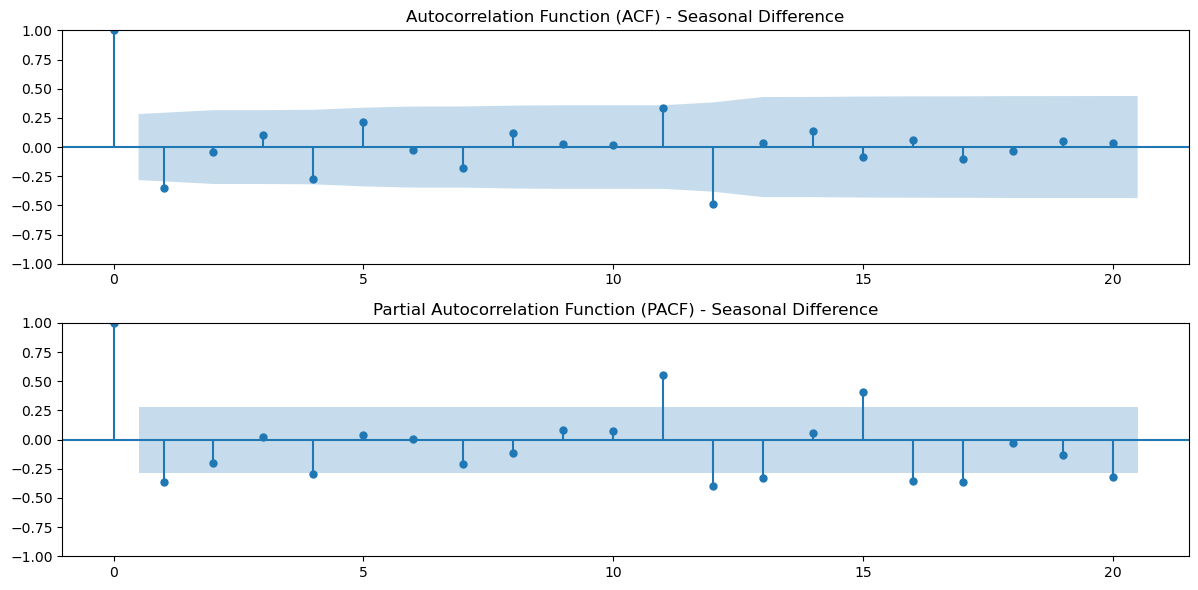

In [41]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_e['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

In [42]:
order_SARIMAX=[]
# Loop over P order
for P in range(5):
    # Loop over Q order
    for Q in range(3):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=54, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [43]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
1   0  1  966.694177  980.402754   9205.660889  9.165124e+07
2   0  2  968.529506  983.951655   8041.028597  6.631686e+07
4   1  1  968.567512  983.989660   7871.246315  6.287111e+07
9   3  0  970.366424  987.502144  11001.345577  1.710750e+08
7   2  1  970.525097  987.660817   7999.953966  6.555926e+07
5   1  2  970.602322  987.738043   8353.725785  7.448273e+07
6   2  0  970.880773  986.302922   9952.463555  1.699563e+08
3   1  0  971.860227  985.568804  14000.870475  2.878044e+08
12  4  0  971.940684  990.789977   7914.540748  7.279165e+07
10  3  1  972.138248  990.987541   9363.691643  9.918586e+07
8   2  2  972.510378  991.359671   8471.931101  7.464583e+07
13  4  1  973.939766  994.502631   7881.336015  7.132104e+07
11  3  2  974.058931  994.621796   8821.246744  8.320591e+07
14  4  2  975.988605  998.265041   8296.273403  7.495967e+07
0   0  0  979.795100  991.790105   3767.297486  2.702826e+07


In [44]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(0,1,1,12))
sarima_model=sarima.fit()

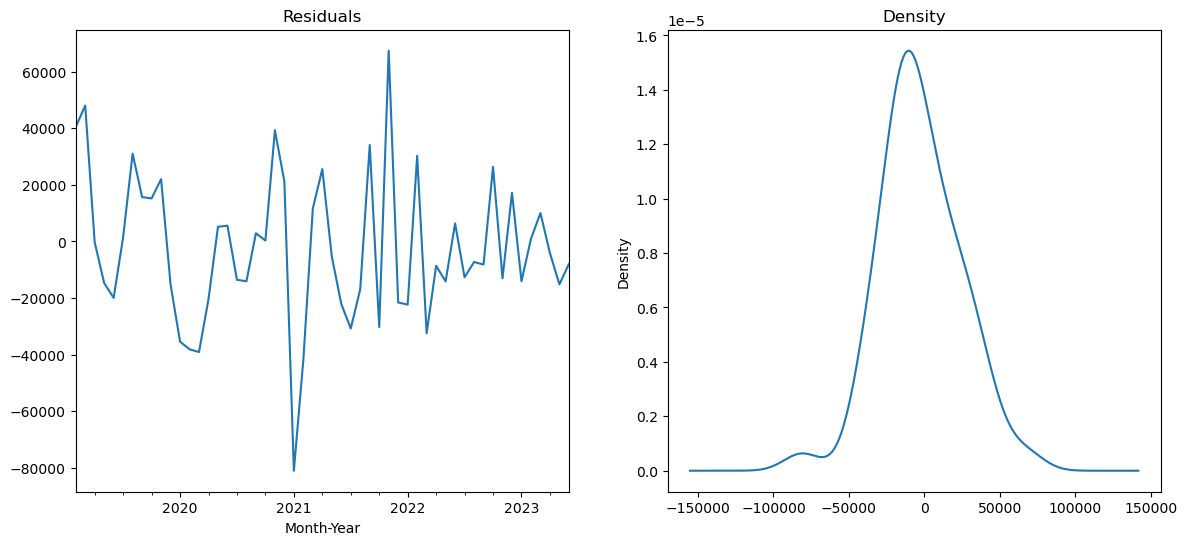

In [45]:
residuals_s= sarima_model.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals_s.plot(title='Residuals',ax=ax[0])
residuals_s.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

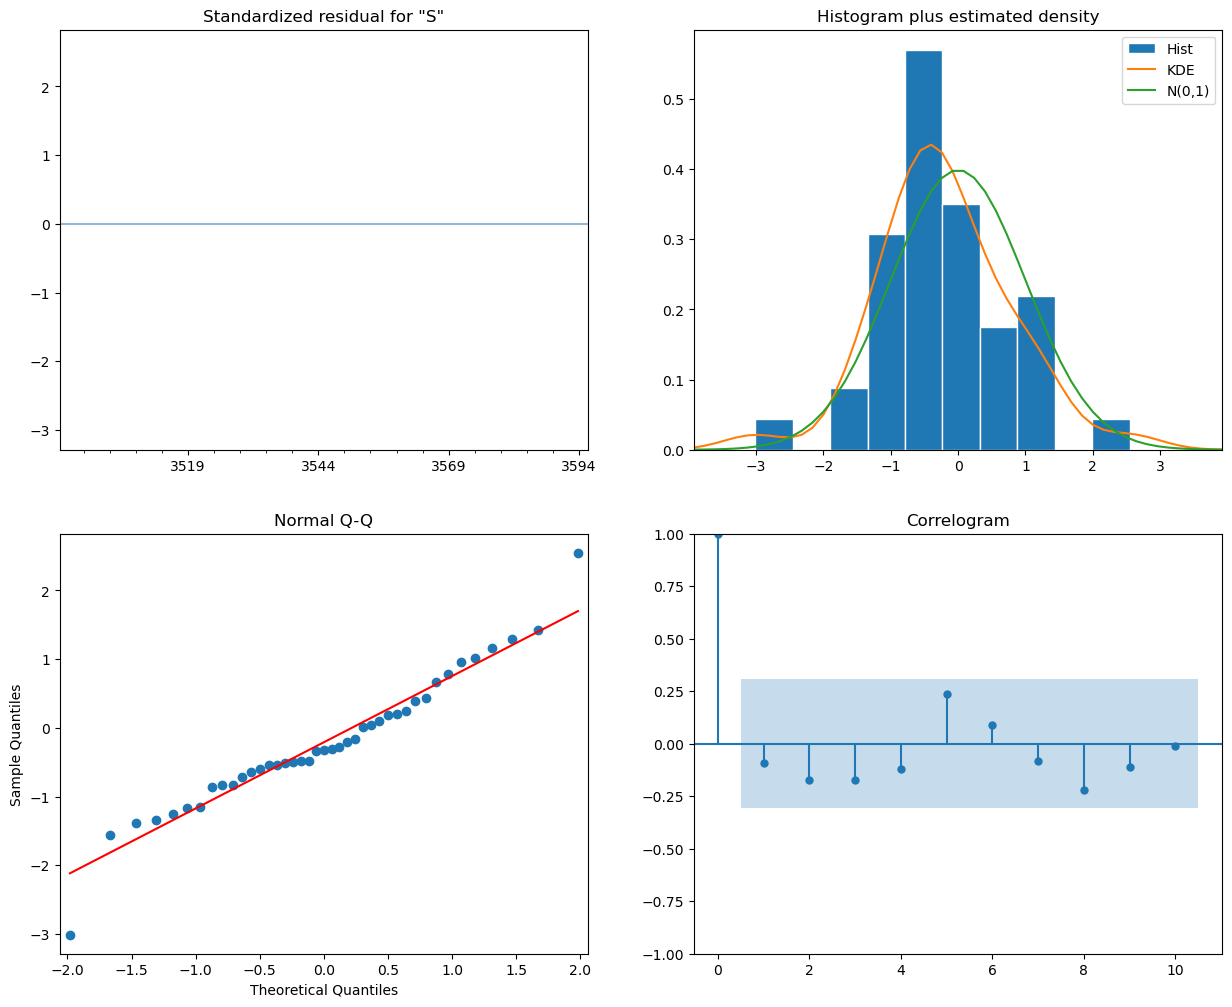

In [46]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [47]:
forecast_test_sarima=sarima_model.predict(start=54,end=59,dynamic=True)

In [48]:
sales_e['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product E')

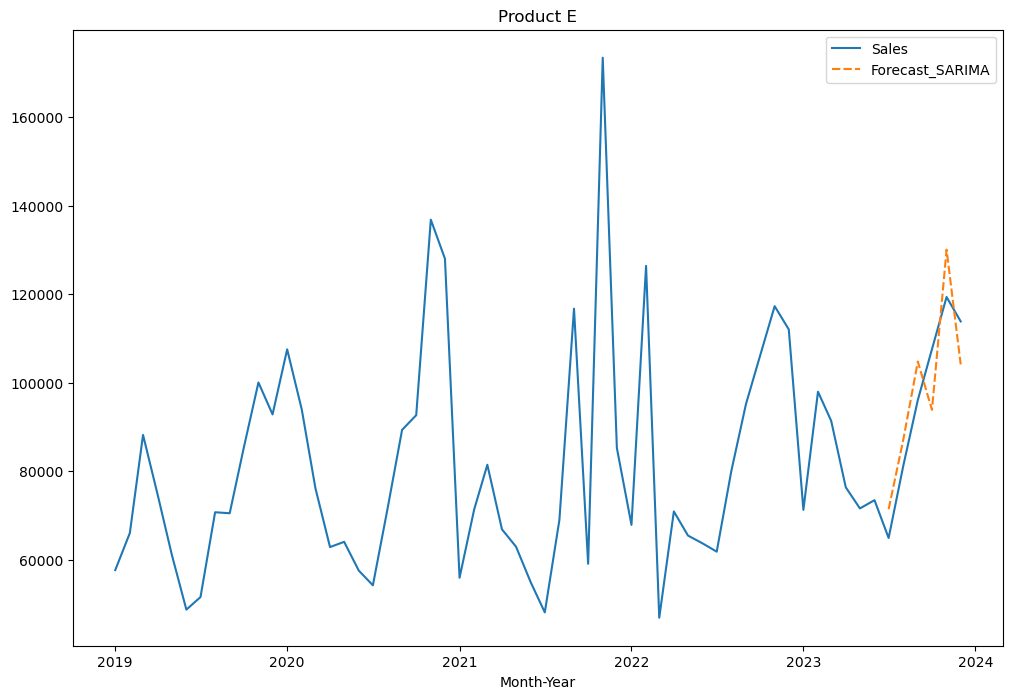

In [49]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_SARIMA']])
plt.title('Product E')

In [50]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 9205.661
MAPE - SARIMA: 0.094
MSE - SARIMA: 91651241.001
RMSE - SARIMA: 9573.465


# FORECASTING

In [51]:
sarima_forecast=sm.tsa.statespace.SARIMAX(sales_e['Sales'],order=(4, 1, 2),seasonal_order=(0,1,1,12))
sarima_model_f=sarima_forecast.fit()

In [52]:
forecast_sarima=sarima_model_f.predict(start=60,end=65,dynamic=True)

In [53]:
forecast_sarima

2024-01-01     90547.822511
2024-02-01    108908.647913
2024-03-01     98908.479816
2024-04-01     91917.567421
2024-05-01     88287.570472
2024-06-01     85869.928716
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product E')

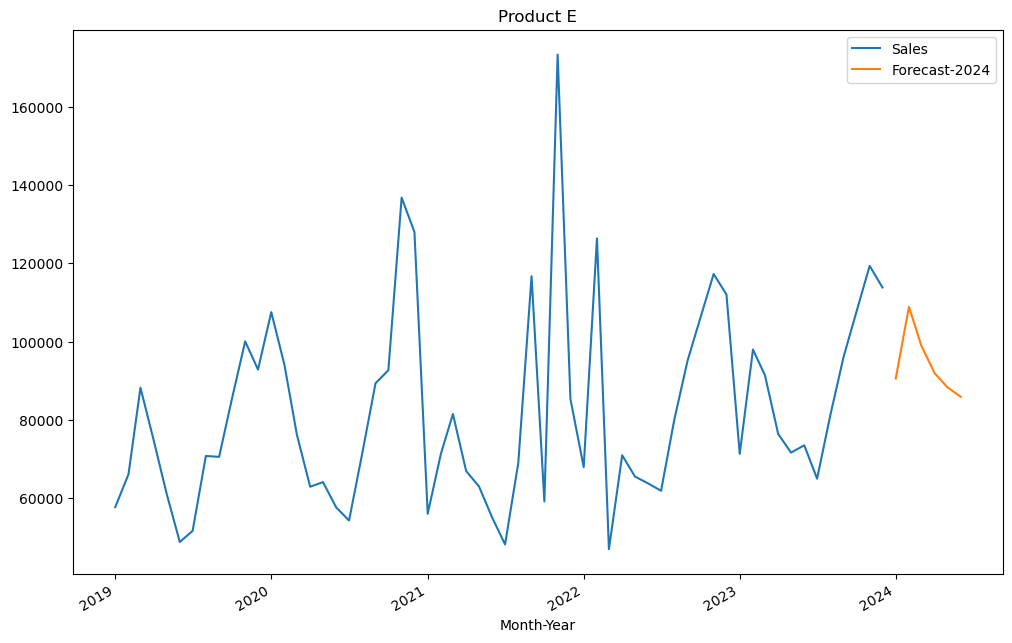

In [54]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales']])
forecast_sarima.plot(legend=True, label='Forecast-2024')
plt.title('Product E')

In [55]:
sarima_forecast_model=sarima_model_f.get_forecast(steps=6)

In [56]:
mean_forecast_sarima= sarima_forecast_model.predicted_mean
dates = mean_forecast_sarima.index

In [57]:
confidence_intervals_sarima= sarima_forecast_model.conf_int()

In [58]:
print(mean_forecast_sarima,confidence_intervals_sarima)

2024-01-01     90547.822511
2024-02-01    108908.647913
2024-03-01     98908.479816
2024-04-01     91917.567421
2024-05-01     88287.570472
2024-06-01     85869.928716
Freq: MS, Name: predicted_mean, dtype: float64              lower Sales    upper Sales
2024-01-01  43704.847741  137390.797281
2024-02-01  60715.927755  157101.368071
2024-03-01  45384.252649  152432.706984
2024-04-01  31858.454409  151976.680432
2024-05-01  26542.218282  150032.922662
2024-06-01  21474.971559  150264.885874


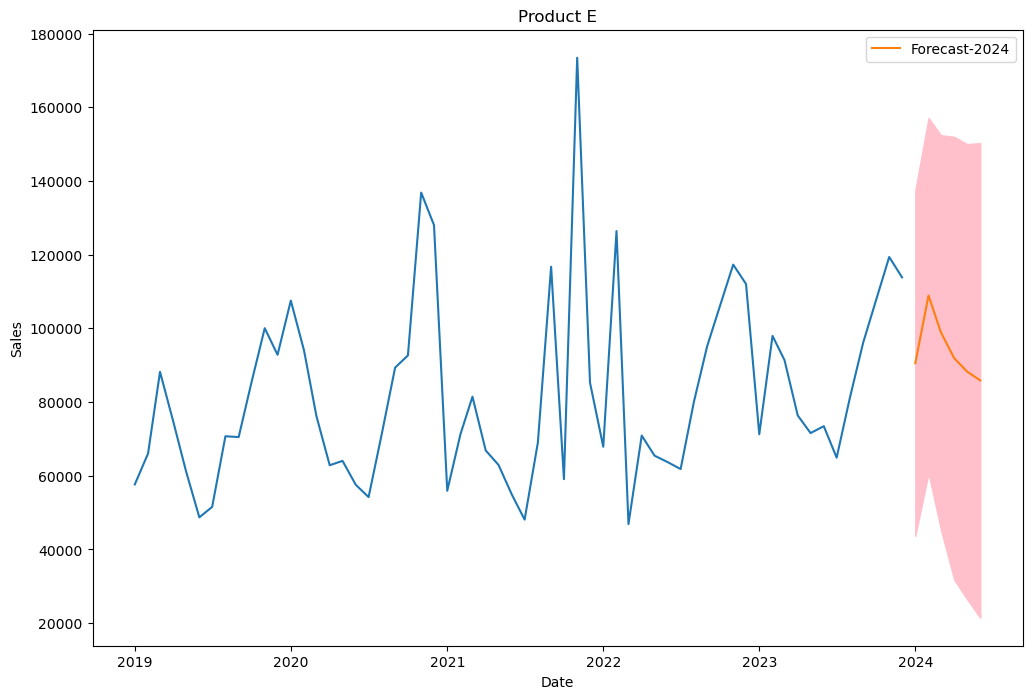

In [59]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=sales_e['Sales']) 
sns.lineplot(data=mean_forecast_sarima, label='Forecast-2024')
plt.fill_between(x=mean_forecast_sarima.index, y1=confidence_intervals_sarima['lower Sales'], y2=confidence_intervals_sarima['upper Sales'], color='pink')
plt.title('Product E')
plt.xlabel('Date') 
plt.ylabel('Sales')  
plt.legend()  
plt.show()

# AUTO-ARIMA

In [43]:
import pmdarima as pm

In [45]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=3 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=994.432, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=980.914, Time=0.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=983.413, Time=0.25 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=985.115, Time=1.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=981.137, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=985.241, Time=0.45 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=986.945, Time=3.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=988.958, Time=0.34 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=987.236, Time=0.81 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=988.914, Time=6.68 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=9.45 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=989.137, Time=5.40 sec
 ARIMA(0,1,0)(4,1,0)[12]  

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [46]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -477.351
Date:                            Thu, 09 May 2024   AIC                            964.702
Time:                                    17:28:41   BIC                            973.270
Sample:                                01-01-2019   HQIC                           967.822
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2128      0.436     -2.781      0.005      -2.068      -0.358
ar.L2         -0.5730      0.210     -2.725      0.006      -0.985      -0.161
ma.L1          0.5891      0.498      1.183      0.237      -0.387       1.565
ma.S.L12      -0.6280      0.218     -2.886      0.004      -1.055      -0.201
sigma2      7.616e+08   3.12e-10   2.44e+18      0.000    7.62e+08    7.62e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.67   Prob(JB):                         0.04
Heteroskedasticity (H):               0.21   Skew:                            -0.63
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+34. Standard errors may be unstable.
"""

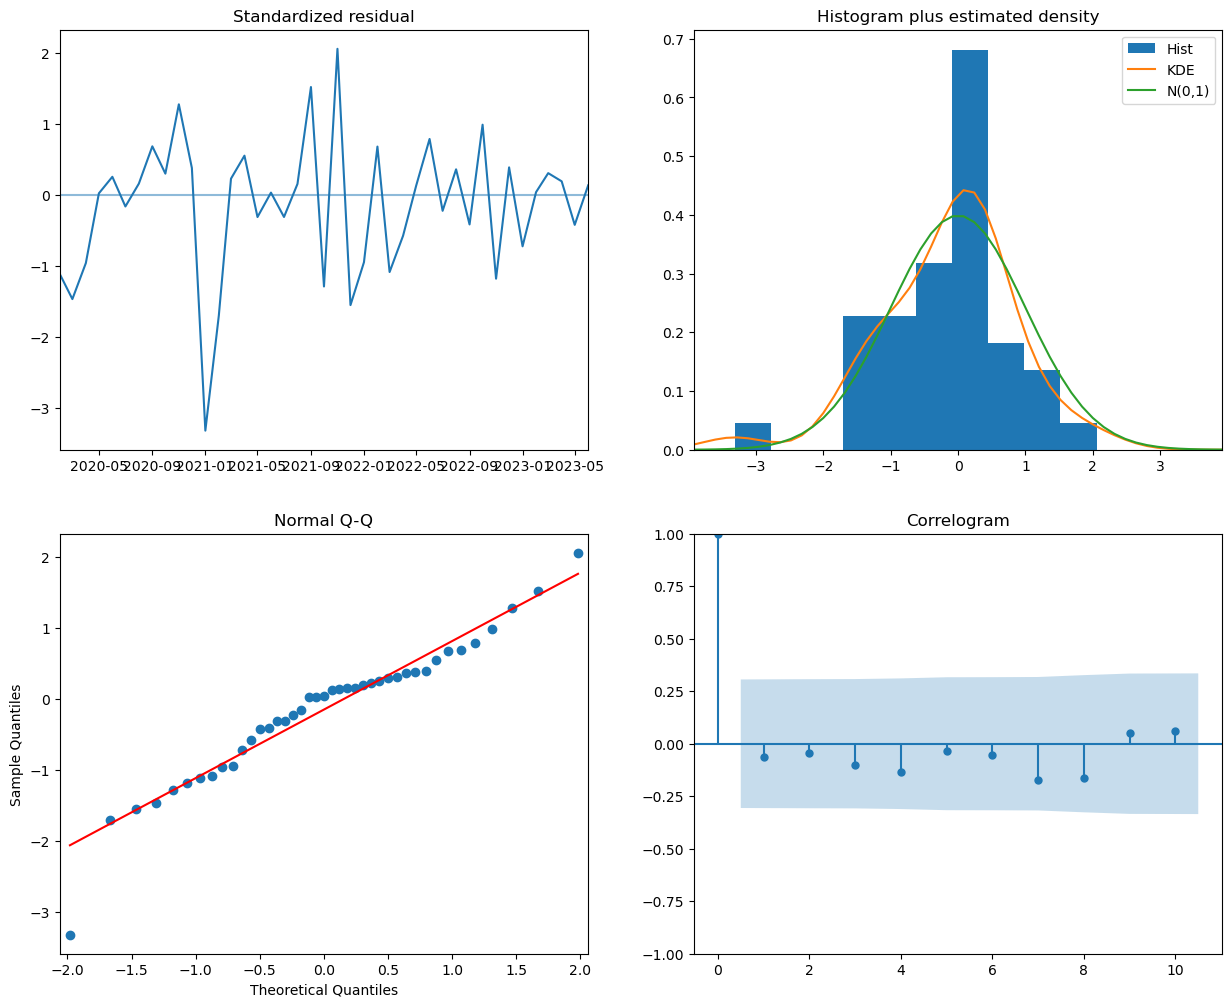

In [47]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [48]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_e['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_e[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product E')

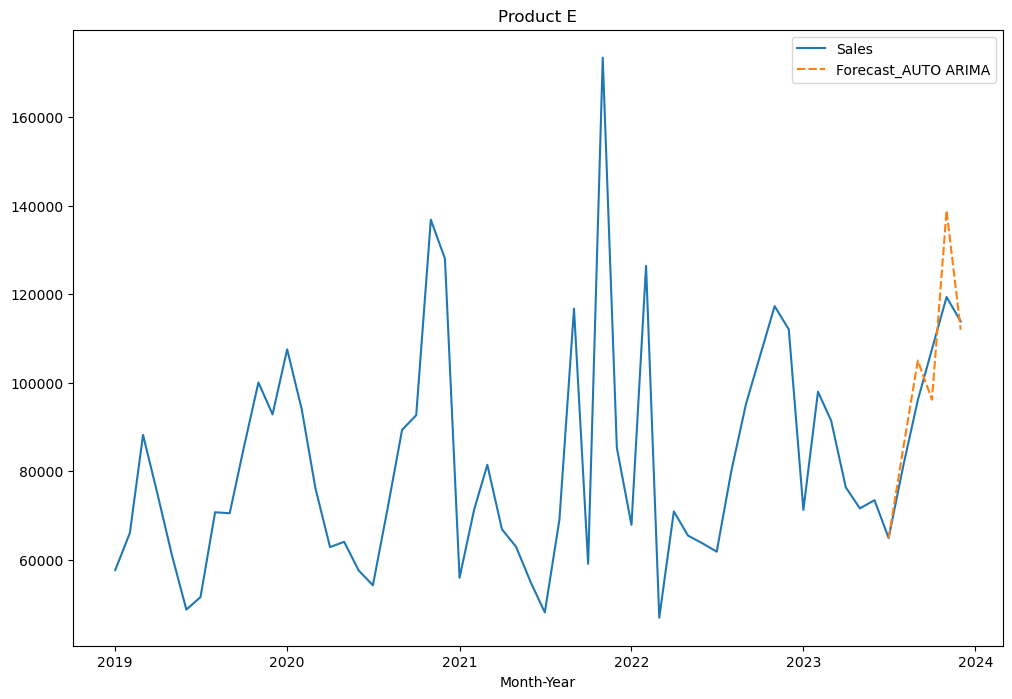

In [49]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product E')

In [50]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 7644.731933646185
MAPE - AUTO ARIMA: 0.07166220284731607
MSE - AUTO ARIMA: 101977596.4388467
RMSE - AUTO ARIMA: 10098.395735900169


In [51]:
sales_e.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,71268,NaN,NaN,NaN
2023-02-01,97965,NaN,NaN,NaN
2023-03-01,91393,NaN,NaN,NaN
2023-04-01,76364,NaN,NaN,NaN
2023-05-01,71591,NaN,NaN,NaN
2023-06-01,73457,NaN,NaN,NaN
2023-07-01,64909,77737.147450,71420.868366,64834.318356
2023-08-01,81175,85544.922202,87062.516409,85200.373639
2023-09-01,96096,94096.190348,104790.851323,105013.853842


In [52]:
sales_e.mean()

Sales                   82098.833333
Forecast_ARIMA          94443.933165
Forecast_SARIMA         98560.167673
Forecast_AUTO ARIMA    100352.861266
dtype: float64

In [53]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,8453.756719,0.091103,9.212786e+07,9598.325977
AUTO ARIMA,7644.731934,0.071662,1.019776e+08,10098.395736
SEASONAL ARIMA,9205.660889,0.094311,9.165124e+07,9573.465465


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=6,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=977.177, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=978.387, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=979.051, Time=0.24 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=978.613, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=979.552, Time=0.28 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=978.276, Time=0.98 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=979.518, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=980.931, Time=0.19 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=980.156, Time=0.46 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=981.102, Time=0.14 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,1)(2,1,0)[12] inter

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   54
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 12)   Log Likelihood                -481.835
Date:                             Wed, 08 May 2024   AIC                            975.669
Time:                                     19:19:32   BIC                            986.095
Sample:                                 01-01-2019   HQIC                           979.491
                                      - 06-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5837.2072   1.14e+04      0.511      0.610   -1.66e+04    2.82e+04
ar.L1         -1.2658      0.136     -9.286      0.000      -1.533      -0.999
ar.L2         -0.9662      0.148     -6.515      0.000      -1.257      -0.676
ma.L1          1.1077      0.195      5.678      0.000       0.725       1.490
ma.L2          0.9038      0.202      4.481      0.000       0.508       1.299
sigma2        5.5e+08      0.183      3e+09      0.000     5.5e+08     5.5e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.40   Prob(JB):                         0.93
Heteroskedasticity (H):               0.39   Skew:                            -0.01
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.34e+25. Standard errors may be unstable.
"""

In [19]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_e['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product E')

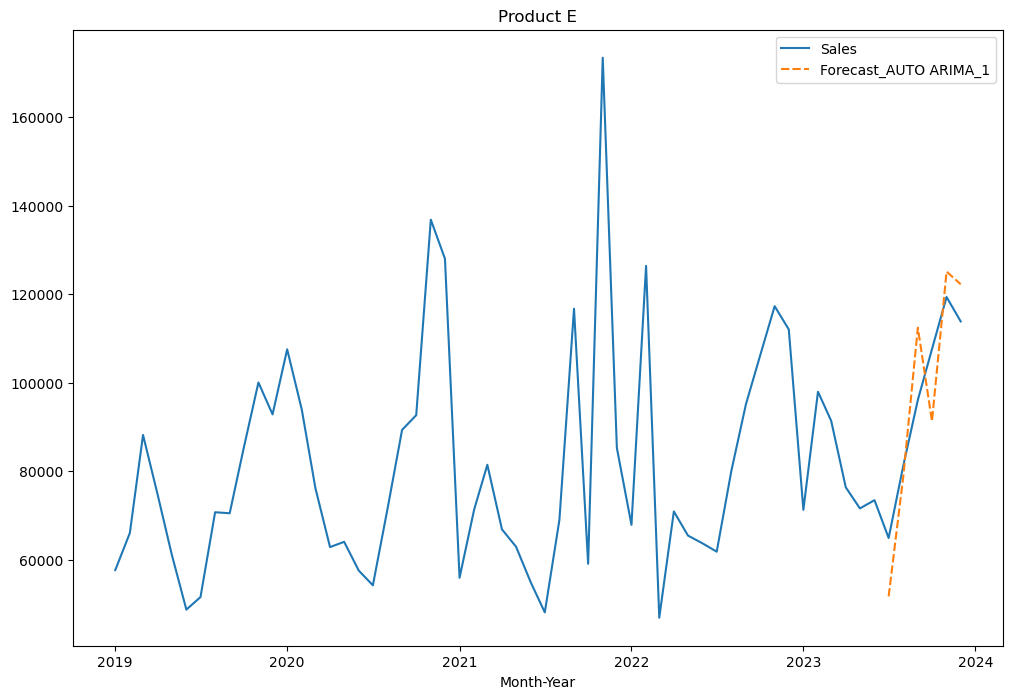

In [20]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product E')

In [21]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 10406.213401087998
MAPE - AUTO ARIMA: 0.11285157780120926
MSE - AUTO ARIMA: 135990092.82854202
RMSE - AUTO ARIMA: 11661.479015482642
